In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

In [2]:
combined_df = retrieve_data()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

only use constant interest rate r + does not incorporate option prices into the calibration process.

!!! calibrate based solely on historical stock price data, particularly the realized volatility of returns.

options data need to be collect more on daily basis from 2024/25/07 to 024/25/10.
i only collected on quaterly basis so now cannot right

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

class HestonModelCalibration:
    def __init__(self, data, n_days=252):
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())
        
    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days
    
    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values

    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        params = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            vol = self.calculate_realized_vol()[ticker].dropna()
            
            def objective(x):
                kappa, theta, sigma, rho = x
                var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
                return np.sum((var_pred - vol) ** 2)
            
            bounds = [(0.1, 10.0),  # kappa
                     (0.001, 0.5),  # theta
                     (0.01, 1.0),   # sigma
                     (-0.99, -0.1)] # rho
            
            result = minimize(objective, 
                            x0=[2.0, vol.mean(), 0.3, -0.7],
                            bounds=bounds,
                            method='L-BFGS-B')
            
            params[ticker] = {
                'kappa': result.x[0],
                'theta': result.x[1],
                'sigma': result.x[2],
                'rho': result.x[3]
            }
        
        return params

def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction='av',
    r=0.01
    ):
    
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)
    
    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))
    
    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]['kappa'] for t in tickers])
    theta = np.array([calibrated_params[t]['theta'] for t in tickers])
    sigma = np.array([calibrated_params[t]['sigma'] for t in tickers])
    rho = np.array([calibrated_params[t]['rho'] for t in tickers])
    
    # Get initial variances
    v0 = {t: calibrated_params[t]['theta'] for t in tickers}
    
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values
        
    # Cholesky decomposition for correlated Brownian motions
    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(correlation_matrix.shape[0])
        chol_corr = np.linalg.cholesky(correlation_matrix)
    
    paths_to_simulate = n_paths // 2 if variance_reduction == 'av' else n_paths
    
    for i in tqdm(range(paths_to_simulate)):
        # Generate and correlate Brownian motions
        dw_s = np.random.normal(size=(n_assets, n_steps))
        dw_v = np.random.normal(size=(n_assets, n_steps))
        dw_s = np.dot(chol_corr, dw_s)
        
        # Correlate price and variance Brownian motions
        for j in range(n_assets):
            dw_v[j] = rho[j] * dw_s[j] + np.sqrt(1 - rho[j]**2) * dw_v[j]
        
        for j in range(n_steps):
            for k in range(n_assets):
                if j == 0:
                    result[k, i, j] = s0[tickers[k]]
                    variance_paths[k, i, j] = v0[tickers[k]]
                    
                    if variance_reduction == 'av':
                        result[k, n_paths - i - 1, j] = s0[tickers[k]]
                        variance_paths[k, n_paths - i - 1, j] = v0[tickers[k]]
                else:
                    v_prev = max(variance_paths[k, i, j-1], 0)
                    
                    # Update variance
                    variance_paths[k, i, j] = (v_prev + 
                        kappa[k] * (theta[k] - v_prev) * dt + 
                        sigma[k] * np.sqrt(v_prev * dt) * dw_v[k, j])
                    
                    # Update price
                    result[k, i, j] = result[k, i, j-1] * np.exp(
                        (r - 0.5 * v_prev) * dt + 
                        np.sqrt(v_prev * dt) * dw_s[k, j])
                    
                    if variance_reduction == 'av':
                        variance_paths[k, n_paths - i - 1, j] = (v_prev + 
                            kappa[k] * (theta[k] - v_prev) * dt + 
                            sigma[k] * np.sqrt(v_prev * dt) * (-dw_v[k, j]))
                        
                        result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                            (r - 0.5 * v_prev) * dt + 
                            np.sqrt(v_prev * dt) * (-dw_s[k, j]))
    
    if variance_reduction == 'emc':
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor
    
    return result, tickers, variance_paths

def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id):
    # Initialize model and calibrate parameters
    close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
    heston_calibration = HestonModelCalibration(close)
    
    prices = []
    for current_id in tqdm(range(backtest_start, backtest_end)):
        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30):current_id]
        
        # Calibrate parameters and get correlation matrix
        calibrated_params = heston_calibration.calibrate_heston_parameters(window_size=30)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(window_size=30)
        
        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            dt=1/252,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            n_paths=1000,
            variance_reduction='av',
            current_id=current_id,
            last_id=last_id
        )
        
        # Construct paths and calculate payoffs
        old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
        old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
        old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

        for i in range(result.shape[1]):
            path_rog = np.append(old_path_rog, result[0][i].flatten())
            path_cfr = np.append(old_path_cfr, result[1][i].flatten())
            path_zurn = np.append(old_path_zurn, result[2][i].flatten())
            
        #     payoff.append(payoff_func(
        #         path_rog, path_cfr, path_zurn, 
        #         combined_df.iloc[current_id]['Date'], 
        #         verbose=False
        #     ))
        
        # prices.append(neutral_pricing(
        #     np.mean(payoff), 
        #     0.01107, 
        #     last_id - current_id
        # ))
            payoff.append(payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False))
        prices.append(np.mean(payoff))
        
    return prices

  2%|▏         | 1/65 [00:01<02:07,  1.99s/it]

1030.047150441568


  3%|▎         | 2/65 [00:03<02:05,  1.99s/it]

1030.099426314412


  5%|▍         | 3/65 [00:05<02:02,  1.97s/it]

1029.912901897052


  6%|▌         | 4/65 [00:07<01:59,  1.96s/it]

1029.7351152266258


  8%|▊         | 5/65 [00:10<02:01,  2.03s/it]

1030.1861753249734


  9%|▉         | 6/65 [00:11<01:58,  2.00s/it]

1028.1870347624026


 11%|█         | 7/65 [00:13<01:54,  1.97s/it]

1029.5307583260337


 12%|█▏        | 8/65 [00:15<01:51,  1.95s/it]

1027.9325578259995


 14%|█▍        | 9/65 [00:17<01:48,  1.93s/it]

1029.2874143854256


 15%|█▌        | 10/65 [00:19<01:47,  1.96s/it]

1028.2820383674111


 17%|█▋        | 11/65 [00:21<01:45,  1.95s/it]

1030.4865414194492


 18%|█▊        | 12/65 [00:23<01:42,  1.93s/it]

1030.0015137116172


 20%|██        | 13/65 [00:25<01:38,  1.90s/it]

1029.8758222157376


 22%|██▏       | 14/65 [00:27<01:35,  1.88s/it]

1030.4676416947643


 23%|██▎       | 15/65 [00:29<01:33,  1.87s/it]

1030.6552912593445


 25%|██▍       | 16/65 [00:30<01:31,  1.86s/it]

1030.7849907993686


 26%|██▌       | 17/65 [00:32<01:28,  1.85s/it]

1031.1878876727512


 28%|██▊       | 18/65 [00:34<01:25,  1.83s/it]

1031.2331872784976


 29%|██▉       | 19/65 [00:36<01:23,  1.82s/it]

1030.4461771457934


 31%|███       | 20/65 [00:38<01:21,  1.80s/it]

1030.8643241439509


 32%|███▏      | 21/65 [00:39<01:20,  1.83s/it]

1031.3690980360295


 34%|███▍      | 22/65 [00:41<01:19,  1.84s/it]

1031.0152920804749


 35%|███▌      | 23/65 [00:43<01:16,  1.83s/it]

1031.4597151588366


 37%|███▋      | 24/65 [00:45<01:15,  1.85s/it]

1031.1063606402756


 38%|███▊      | 25/65 [00:47<01:13,  1.83s/it]

1031.155134648741


 40%|████      | 26/65 [00:49<01:10,  1.81s/it]

1030.7607643359922


 42%|████▏     | 27/65 [00:50<01:08,  1.80s/it]

1031.640973290284


 43%|████▎     | 28/65 [00:52<01:06,  1.80s/it]

1030.4229114923685


 45%|████▍     | 29/65 [00:54<01:03,  1.77s/it]

1031.7316143003234


 46%|████▌     | 30/65 [00:55<01:00,  1.74s/it]

1031.0957426049908


 48%|████▊     | 31/65 [00:57<00:58,  1.71s/it]

1030.2051508710952


 49%|████▉     | 32/65 [00:59<00:55,  1.69s/it]

1030.7278129445049


 51%|█████     | 33/65 [01:00<00:53,  1.68s/it]

1031.9129202125318


 52%|█████▏    | 34/65 [01:02<00:51,  1.66s/it]

1029.3691274339508


 54%|█████▍    | 35/65 [01:04<00:51,  1.72s/it]

1013.0011148467235


 55%|█████▌    | 36/65 [01:06<00:50,  1.76s/it]

1014.1493351871889


 57%|█████▋    | 37/65 [01:08<00:49,  1.77s/it]

1013.8972661796411


 58%|█████▊    | 38/65 [01:09<00:48,  1.78s/it]

1014.3039897129772


 60%|██████    | 39/65 [01:11<00:46,  1.77s/it]

1012.5421917178676


 62%|██████▏   | 40/65 [01:13<00:43,  1.76s/it]

1014.0100709928722


 63%|██████▎   | 41/65 [01:15<00:41,  1.74s/it]

1014.0626772537621


 65%|██████▍   | 42/65 [01:16<00:39,  1.72s/it]

1014.4214198536179


 66%|██████▌   | 43/65 [01:18<00:37,  1.72s/it]

1012.8337764407784


 68%|██████▊   | 44/65 [01:20<00:36,  1.72s/it]

1014.5498359093051


 69%|██████▉   | 45/65 [01:21<00:34,  1.71s/it]

1014.5696323648176


 71%|███████   | 46/65 [01:23<00:32,  1.70s/it]

1015.0446147089748


 72%|███████▏  | 47/65 [01:25<00:30,  1.69s/it]

1015.0892051482251


 74%|███████▍  | 48/65 [01:26<00:28,  1.69s/it]

1015.1337975463128


 75%|███████▌  | 49/65 [01:28<00:26,  1.68s/it]

1015.178391903324


 77%|███████▋  | 50/65 [01:30<00:24,  1.66s/it]

1015.2229882193444


 78%|███████▊  | 51/65 [01:31<00:23,  1.66s/it]

1015.2675864944605


 80%|████████  | 52/65 [01:33<00:21,  1.63s/it]

1015.3121867287581


 82%|████████▏ | 53/65 [01:34<00:19,  1.62s/it]

1015.3567889223232


 83%|████████▎ | 54/65 [01:36<00:17,  1.61s/it]

1015.401393075242


 85%|████████▍ | 55/65 [01:38<00:16,  1.60s/it]

1015.4459991876007


 86%|████████▌ | 56/65 [01:39<00:14,  1.59s/it]

1015.4906072594852


 88%|████████▊ | 57/65 [01:41<00:12,  1.61s/it]

1015.5352172909814


 89%|████████▉ | 58/65 [01:42<00:11,  1.59s/it]

1015.5798292821759


 91%|█████████ | 59/65 [01:44<00:09,  1.57s/it]

1015.6244432331542


 92%|█████████▏| 60/65 [01:46<00:09,  1.86s/it]

1015.6690591440029


 94%|█████████▍| 61/65 [01:48<00:07,  1.77s/it]

1015.7136770148078


 95%|█████████▌| 62/65 [01:50<00:05,  1.84s/it]

1015.3611474907607


 97%|█████████▋| 63/65 [01:52<00:03,  1.76s/it]

1015.8029186366307


 98%|█████████▊| 64/65 [01:53<00:01,  1.69s/it]

1015.847542387821


100%|██████████| 65/65 [01:55<00:00,  1.77s/it]
/Users/linhtrankhanh/Documents/GitHub/mh4518_simulation_in_fin/notebooks/../utils/utils.py:146: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


1015.892168099312


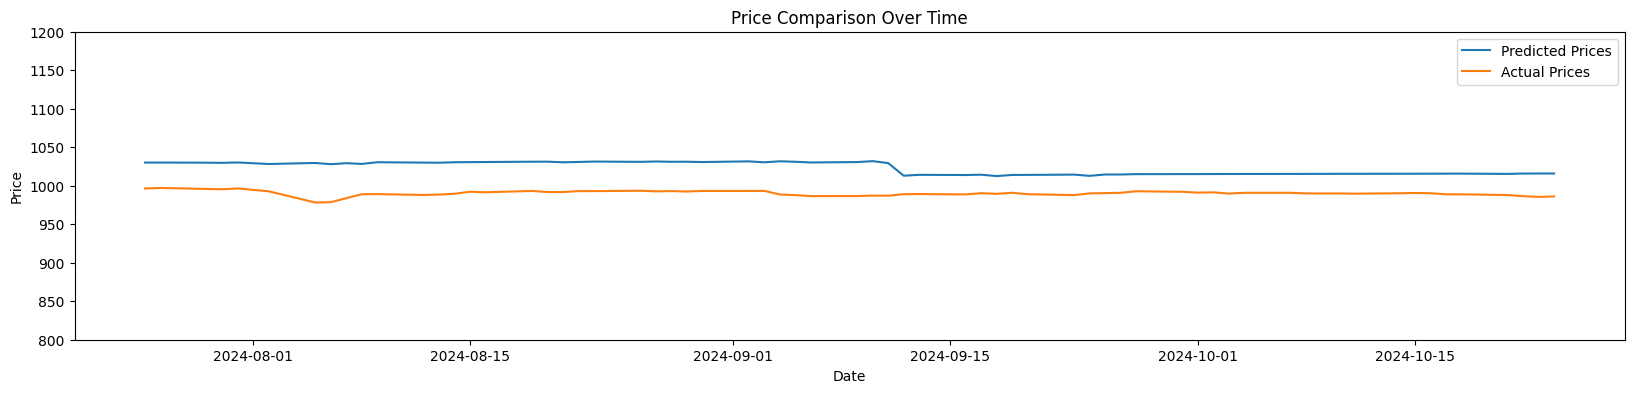

In [ ]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 252

# Run backtest
prices = run_heston_backtest(
    combined_df,
    backtest_start=187,
    backtest_end=197,
    last_id=287
)

# Evaluate results
evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    prices
)